In [2]:
from enum import Enum
from typing import List, Dict, Optional, Tuple
from pandas import DataFrame
from query_lyrics import SongLyric
import analyze_lyrics as analy
import altair as alt
import seaborn as sns


## Which Songs have their title in the refrain the most?
Some songs have really uncreative refrains. We want to check which songs repeat their title the most often in the chorus.

In [3]:
# Get Results
lyrics_to_analyze: List[SongLyric] = analy.load_songs()
occurences: List[int] = []
for song in lyrics_to_analyze:
    parts: Dict[str, str] = analy.get_lyrics_split_up_in_parts(song.lyric)
    hook_lyrics: Optional[str] = analy.get_hook_lyrics(parts)
    if not hook_lyrics:
        occurences.append(0)
        continue
    occurence = analy.find_all(hook_lyrics.lower(),song.song_info.title.lower())
    occurences.append(len(occurence))

# Print Results
combined: List[Tuple[SongLyric, int]] = list(zip(lyrics_to_analyze, occurences))
sorted_by_most_occurence = sorted(combined, key=lambda song_occurence: song_occurence[1], reverse=True)
for song_info, occurence in sorted_by_most_occurence[:10]:
    print(f"{song_info.song_info.title} by {song_info.song_info.artist} was sung {occurence} times in the refrain.")
    parts: Dict[str, str] = analy.get_lyrics_split_up_in_parts(song_info.lyric)
    hook_lyrics: Optional[str] = analy.get_hook_lyrics(parts)
    print(f"{hook_lyrics}")

ERROR:root:Something wrong, we just skip this
Traceback (most recent call last):
  File "/Users/linusheinzl/Documents/Fun/song-analysis/analyze_lyrics.py", line 39, in get_hook_lyrics
    hook_lyrics = [lyric for part,lyric in parts.items() if any([key in part for key in CHORUS_KEYS]) and not "Pre-Chorus" in part][0]
IndexError: list index out of range


Crazy by K-Ci & JoJo was sung 26 times in the refrain.

I'm going crazy, crazy, crazy, just to thinking about you lately (crazy baby)
I'm going crazy, crazy, crazy, just to thinking about you, baby (I don't know
What to do)
I'm going crazy, crazy, crazy, crazy, thinking about you lately (crazy, crazy
Crazy)
I'm going crazy, crazy (crazy, crazy) when I can't touch you
Crazy, crazy (I'm going crazy) when I can't hold you
Crazy, crazy, (I'm going crazy) when I can't see you again
(Said I'm going crazy)
(Said I'm going crazy)


Gucci Gang by Lil Pump was sung 26 times in the refrain.

Gucci gang, Gucci gang, Gucci gang, Gucci gang (Gucci gang)
Gucci gang, Gucci gang, Gucci gang (Gucci gang)
Spend three racks on a new chain (Yuh)
My bitch love do cocaine, ooh (Ooh)
I fuck a bitch, I forgot her name (Brr, yuh)
I can't buy a bitch no wedding ring (Ooh)
Rather go and buy Balmains (Brr)
Gucci gang, Gucci gang, Gucci gang (Gucci gang)
Gucci gang, Gucci gang, Gucci gang, Gucci gang (Gucci gang)
G

## What is the most popular last word of a hook?
I often have the feeling that a lot of songs end their hook with "tonight". But is this true? Actually, tonight is the 12th most used last word of a hook.

In [4]:
def get_without_weird_chars(string_to_replace: str) -> str:
    assert string_to_replace is not None
    return string_to_replace.replace(")", "").replace("\'", "").replace("\"","").replace("(", "").replace(".", "").replace("!", "").replace("?","").replace("\n", "")

# Get Results
lyrics_to_analyze: List[SongLyric] = analy.load_songs()
word_count: Dict[str, List[SongLyric]] = {}
for song in lyrics_to_analyze:
    
    # Get Last Word Of Refrain
    parts: Dict[str, str] = analy.get_lyrics_split_up_in_parts(song.lyric)
    hook_lyrics: Optional[str] = analy.get_hook_lyrics(parts)
    if not hook_lyrics:
        continue
    without_weird_chars = get_without_weird_chars(hook_lyrics)
    last_word = without_weird_chars.split(" ")[-1]
    
    # Increase Counter
    if not last_word in word_count.keys():
        word_count[last_word] = [song]
    else: 
        word_count[last_word].append(song)

ERROR:root:Something wrong, we just skip this
Traceback (most recent call last):
  File "/Users/linusheinzl/Documents/Fun/song-analysis/analyze_lyrics.py", line 39, in get_hook_lyrics
    hook_lyrics = [lyric for part,lyric in parts.items() if any([key in part for key in CHORUS_KEYS]) and not "Pre-Chorus" in part][0]
IndexError: list index out of range


In [5]:
# Print Results
sorted_by_count: List[Tuple[str, List[SongLyric]]] = sorted(word_count.items(), key=lambda word_number: len(word_number[1]), reverse=True)
for word, songs in sorted_by_count[:20]:
    print(f"\"{word}\" was used {len(songs)} times as the last word:")
    for song in songs:
        print(f"{song.song_info.title} by {song.song_info.artist}")
    print("")

"you" was used 61 times as the last word:
Amazed by Lonestar
I Turn To You by Christina Aguilera
I Need You by LeAnn Rimes
This I Promise You by 'N Sync
If You're Gone by matchbox twenty
Hanging By A Moment by Lifehouse
Missing You by Case
U Remind Me by Usher
Fallin' by Alicia Keys
Hero by Enrique Iglesias
Foolish by Ashanti
I Care 4 U by Aaliyah
Miss You by Aaliyah
Numb by Linkin Park
The Reason by Hoobastank
On The Way Down by Ryan Cabrera
Baby I'm Back by Baby Bash Featuring Akon
You And Me by Lifehouse
Cater 2 U by Destiny's Child
Let Me Hold You by Bow Wow Featuring Omarion
Like You by Bow Wow Featuring Ciara
I'm Sprung by T-Pain
Stickwitu by The Pussycat Dolls
Check On It by Beyonce Featuring Slim Thug
You're Beautiful by James Blunt
Love by Keyshia Cole
Wait For You by Elliott Yamin
Paralyzer by Finger Eleven
Over You by Daughtry
No One by Alicia Keys
Clumsy by Fergie
Tattoo by Jordin Sparks
Shadow Of The Day by Linkin Park
With You by Chris Brown
Use Somebody by Kings Of Leon


## Where are the refrain names placed the most often?
I often have the feeling that refrains end with the song's title. But is it true?

In [6]:
class RefrainType(str, Enum):
    TITLE_IN_BEGINNING = "Beginning",
    TITLE_IN_END = "End",
    TITLE_IN_BOTH = "Both",
    TITLE_IN_NEITHER = "Other Part",
    CONTAINS_NO_TITLE = "No Title"
    

def get_type_of_refrain(refrain: str, title: str) -> RefrainType:
    # Find All Occurences And Return If No Found
    occurences: List[int] = analy.find_all(refrain, title)
    if len(occurences) == 0:
        return RefrainType.CONTAINS_NO_TITLE
    # Calculate Type Of Refrain 
    refrain_begins_with_title: bool = occurences[0] == 0
    refrain_ends_with_title: bool = occurences[-1] == len(refrain) - len(title)
    if refrain_begins_with_title and refrain_ends_with_title:
        return RefrainType.TITLE_IN_BOTH
    elif refrain_begins_with_title:
        return RefrainType.TITLE_IN_BEGINNING
    elif refrain_ends_with_title:
        return RefrainType.TITLE_IN_END
    elif len(occurences) > 0:
        return RefrainType.TITLE_IN_NEITHER


# Load Songs
songs_to_analyze: List[SongLyric] = analy.load_songs()
refrain_lyrics_type: Dict[str, int] = {}

for song in songs_to_analyze:
    # Prepare Hooktext and Songtitle
    parts: Dict[str, str] = analy.get_lyrics_split_up_in_parts(song.lyric)
    hook_lyrics: str = analy.get_hook_lyrics(parts)
    if not hook_lyrics:
        continue
    hook_in_comparable_format: str = get_without_weird_chars(hook_lyrics).lower()
    title_in_comparable_format: str = get_without_weird_chars(song.song_info.title).lower()
    
    # Count How Often Type Occurs
    type: RefrainType = get_type_of_refrain(hook_in_comparable_format, title_in_comparable_format)
    if type.value not in refrain_lyrics_type:
        refrain_lyrics_type[type.value] = 0
    else:
        refrain_lyrics_type[type.value] += 1

ERROR:root:Something wrong, we just skip this
Traceback (most recent call last):
  File "/Users/linusheinzl/Documents/Fun/song-analysis/analyze_lyrics.py", line 39, in get_hook_lyrics
    hook_lyrics = [lyric for part,lyric in parts.items() if any([key in part for key in CHORUS_KEYS]) and not "Pre-Chorus" in part][0]
IndexError: list index out of range


<AxesSubplot:xlabel='Where is the title in the refrain?', ylabel='Count'>

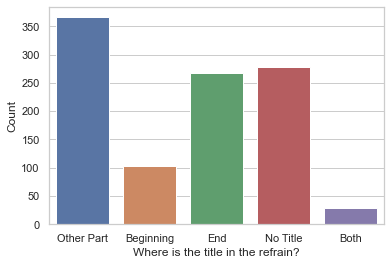

In [7]:
source = DataFrame({
    'Where is the title in the refrain?': list(refrain_lyrics_type.keys()),
    'Count': list(refrain_lyrics_type.values())
})
sns.set_theme(style="whitegrid")
sns.barplot(x="Where is the title in the refrain?", y="Count", data=source)

In [9]:
songs: List[SongLyric] = analy.load_songs()
with_length: List[SongLyric] = [song for song in songs if song.song_info.length_in_seconds is not None]
for i in range(10):
    minIndex = i * 80
    maxIndex = (i+1) * 80
    average = sum([song.song_info.length_in_seconds for song in with_length[minIndex:maxIndex]]) / 80
    print(average)

820
229.65
239.175
233.45
232.125
232.175
244.825
207.85
218.275
217.7
200.0
